<a href="https://colab.research.google.com/github/20pt32/ZerDown-Hackathon/blob/main/DataGenie_Hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
#importing the necessary libraries

import warnings
from math import sqrt
import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  
import pmdarima as pm
import shap
import statsmodels as sm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from prophet import Prophet
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller




# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.


2.11.0


In [11]:
#Load the dataset and quick preview
data = pd.read_csv('sample_1 (1).csv', parse_dates=['point_timestamp'])
data.set_index('point_timestamp', inplace=True)
data.head()

,Unnamed: 0,point_value
point_timestamp,,
2019-07-14,0,6
2019-07-15,1,7
2019-07-16,2,6
2019-07-17,3,6
2019-07-18,4,7


In [ ]:
import numpy as np


class Evaluator(object):
    def __init__(self, num_class):
        self.num_class = num_class
        self.confusion_matrix = np.zeros((self.num_class,)*2)

    def Pixel_Accuracy(self):
        Acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return Acc

    def Pixel_Accuracy_Class(self):
        Acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
        Acc = np.nanmean(Acc)
        return Acc

    def Mean_Intersection_over_Union(self):
        MIoU = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))
        MIoU = np.nanmean(MIoU)
        return MIoU

    def Frequency_Weighted_Intersection_over_Union(self):
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))

        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        assert gt_image.shape == pre_image.shape
        self.confusion_matrix += self._generate_matrix(gt_image, pre_image)

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

In [14]:
import numpy as np
from sklearn.metrics import r2_score

EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """Naive forecasting method which just repeats previous samples"""
    return actual[:-seasonality]


def _relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) / (
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
            + EPSILON
        )

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Bounded Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
        )
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """Geometric mean"""
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """Mean Squared Error"""
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Root Mean Squared Error"""
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """Mean Error"""
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """Geometric Mean Absolute Error"""
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """Median Absolute Error"""
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """Mean Percentage Error"""
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Error"""
    __mae = mae(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted) - __mae)) / (len(actual) - 1)
    )


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Percentage Error"""
    __mape = mape(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_percentage_error(actual, predicted) - __mape))
        / (len(actual) - 1)
    )


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """Root Mean Squared Scaled Error"""
    q = np.abs(_error(actual, predicted)) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """Integral Normalized Root Squared Error"""
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted)))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """Root Relative Squared Error"""
    return np.sqrt(
        np.sum(np.square(actual - predicted))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Error"""
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """Relative Absolute Error (aka Approximation Error)"""
    return np.sum(np.abs(actual - predicted)) / (
        np.sum(np.abs(actual - np.mean(actual))) + EPSILON
    )


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Absolute Error"""
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Median Relative Absolute Error"""
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Geometric Mean Relative Absolute Error"""
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Bounded Relative Absolute Error"""
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Unscaled Mean Bounded Relative Absolute Error"""
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """Mean Directional Accuracy"""
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])
        ).astype(int)
    )


def bias(actual: np.ndarray, predicted: np.ndarray):
    """Mean forecast error(or Forecast Bias)"""
    return np.mean(actual - predicted)


METRICS = {
    "mse": mse,
    "rmse": rmse,
    "nrmse": nrmse,
    "me": me,
    "mae": mae,
    "mad": mad,
    "gmae": gmae,
    "mdae": mdae,
    "mpe": mpe,
    "mape": mape,
    "mdape": mdape,
    "smape": smape,
    "smdape": smdape,
    "maape": maape,
    "mase": mase,
    "std_ae": std_ae,
    "std_ape": std_ape,
    "rmspe": rmspe,
    "rmdspe": rmdspe,
    "rmsse": rmsse,
    "inrse": inrse,
    "rrse": rrse,
    "mre": mre,
    "rae": rae,
    "mrae": mrae,
    "mdrae": mdrae,
    "gmrae": gmrae,
    "mbrae": mbrae,
    "umbrae": umbrae,
    "mda": mda,
    "bias": bias,
    "r2": r2_score,
}


def evaluate(
    actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "rmse", "mape", "r2")
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

In [13]:
data.describe()

,Unnamed: 0,point_value
count,745.000000,745.000000
mean,372.000000,7.088591
std,215.207264,0.548891
min,0.000000,6.000000
25%,186.000000,7.000000
50%,372.000000,7.000000
75%,558.000000,7.000000
max,744.000000,8.000000


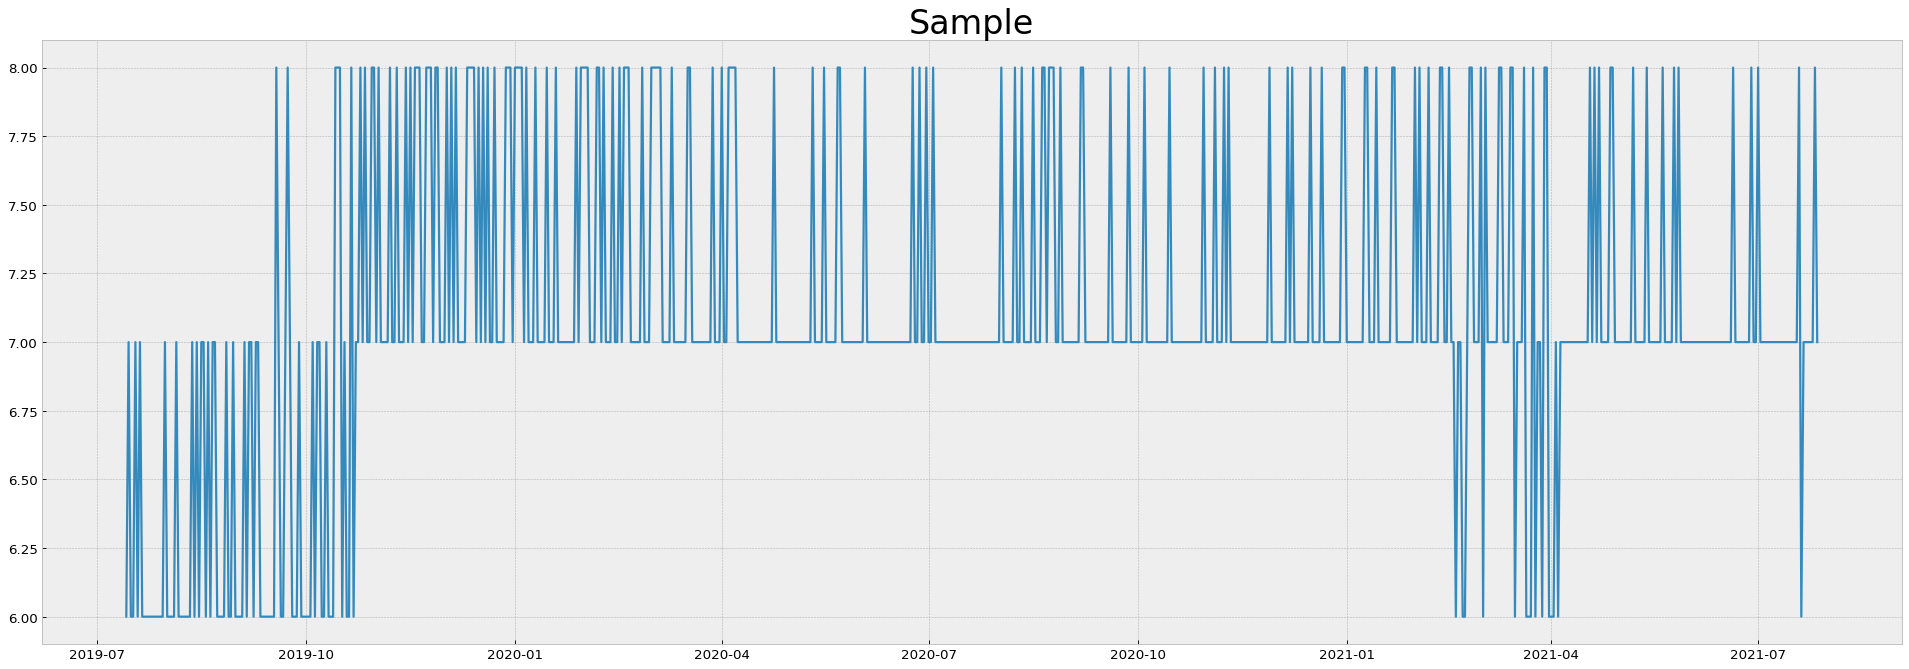

In [15]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Sample', fontsize=30)

plt.plot(data.point_value)


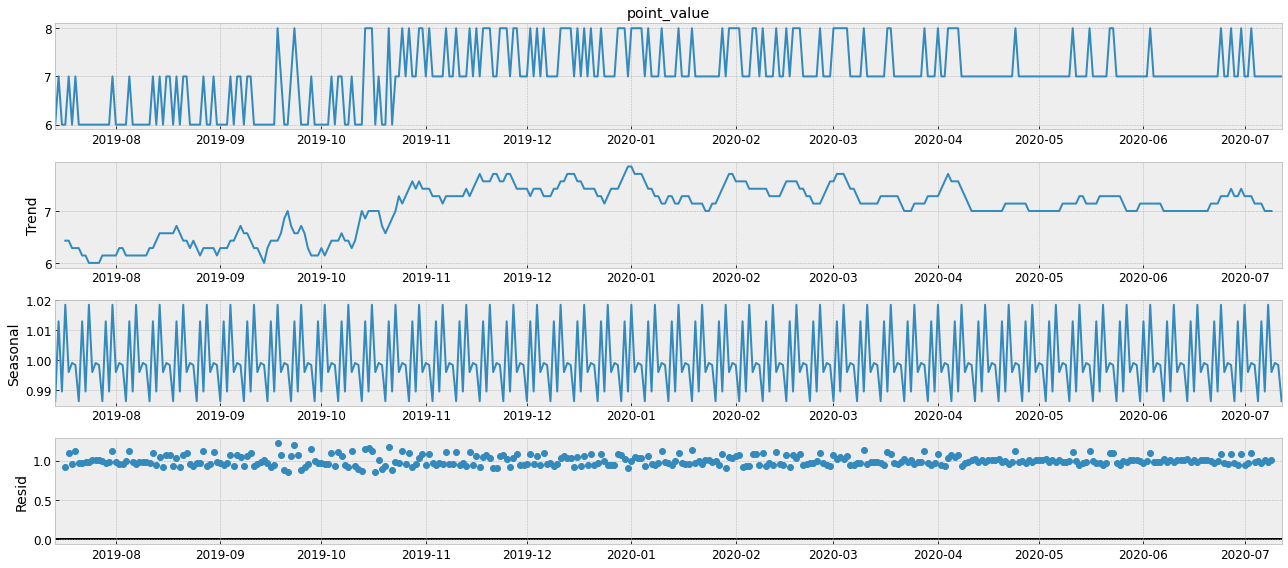

<Figure size 4000x1600 with 0 Axes>

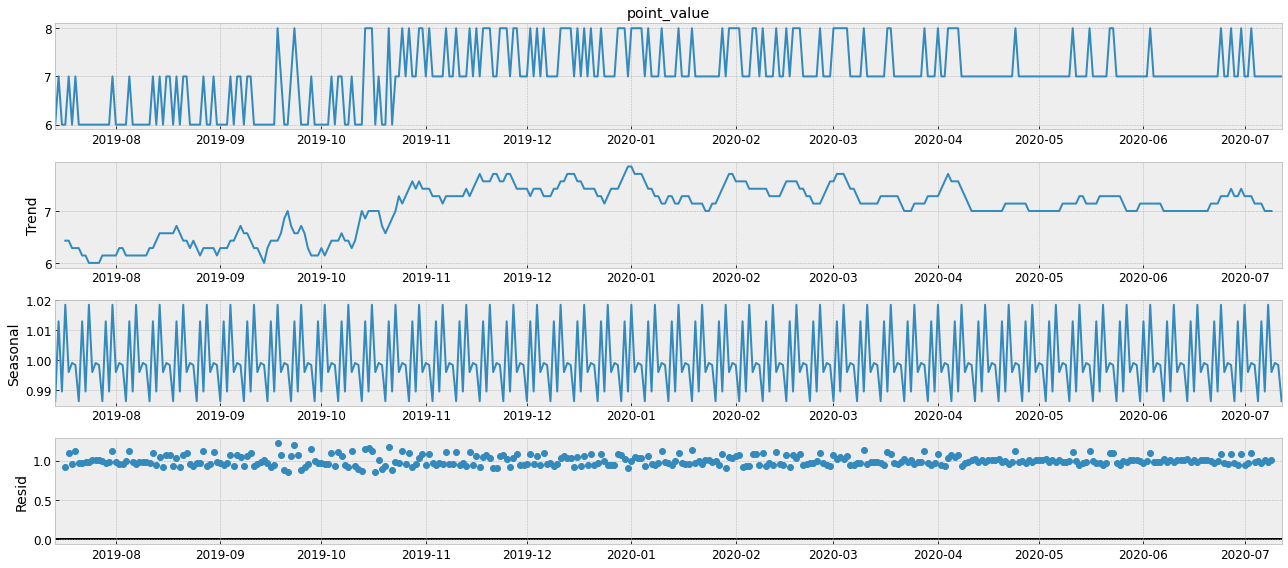

In [16]:
#Decomposing our time series
#Automatic time series decomposition
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = data.point_value[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

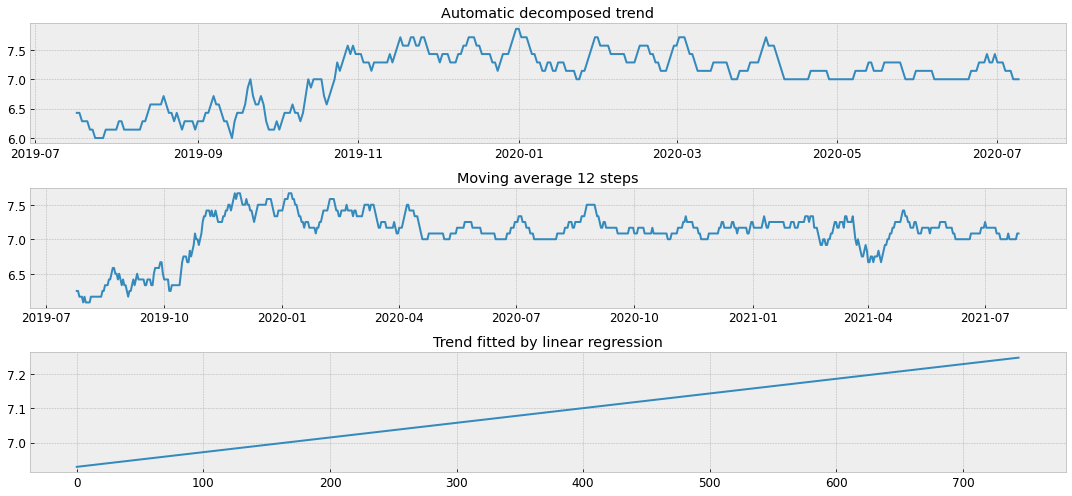

In [17]:
#Trend
#Now we will try some methods to check for trend in our series:

#Automatic decomposing
#Moving average
#Fit a linear regression model to identify trend
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = data.point_value.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(data.point_value))]
X = np.reshape(X, (len(X), 1))
y = data.point_value
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

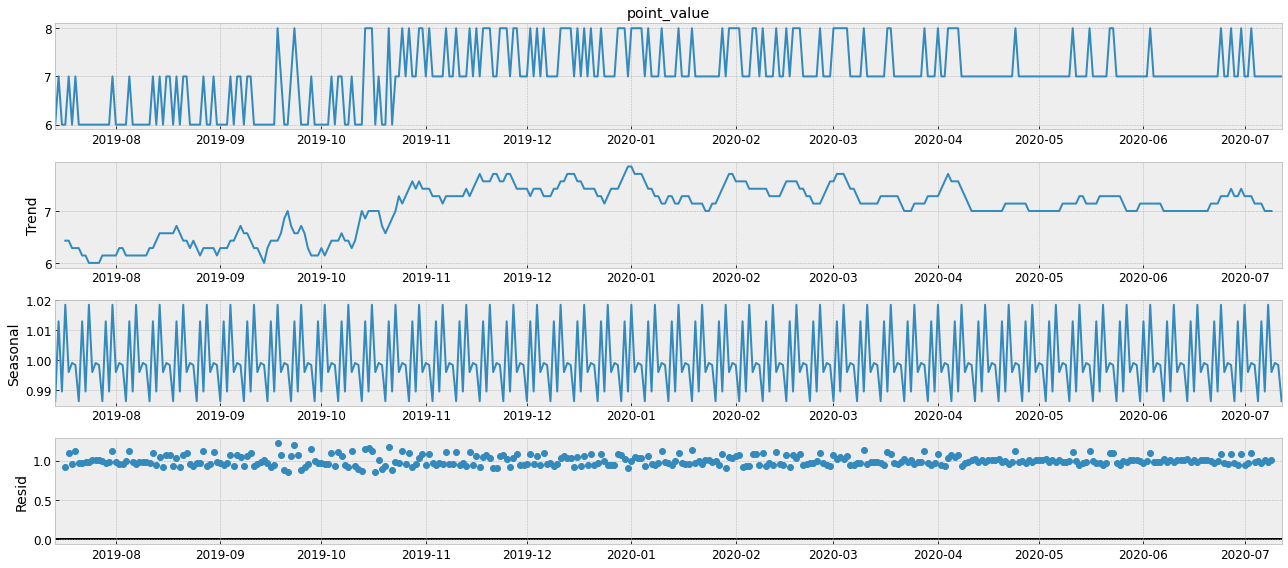

<Figure size 4000x1600 with 0 Axes>

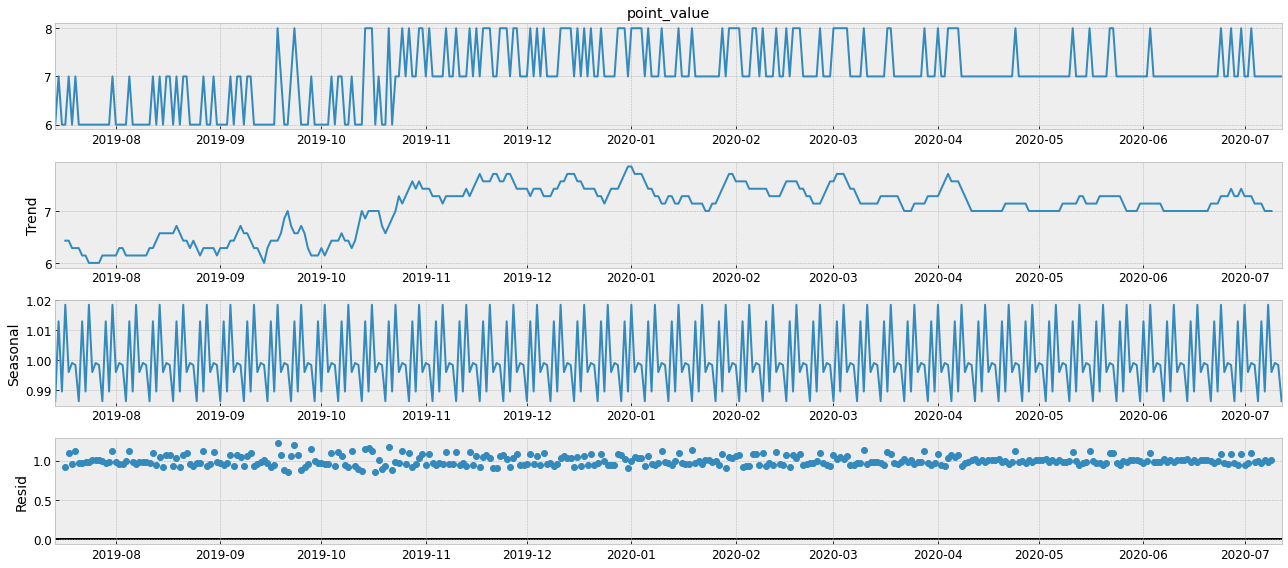

In [18]:
#Seasonality
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = data.point_value[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

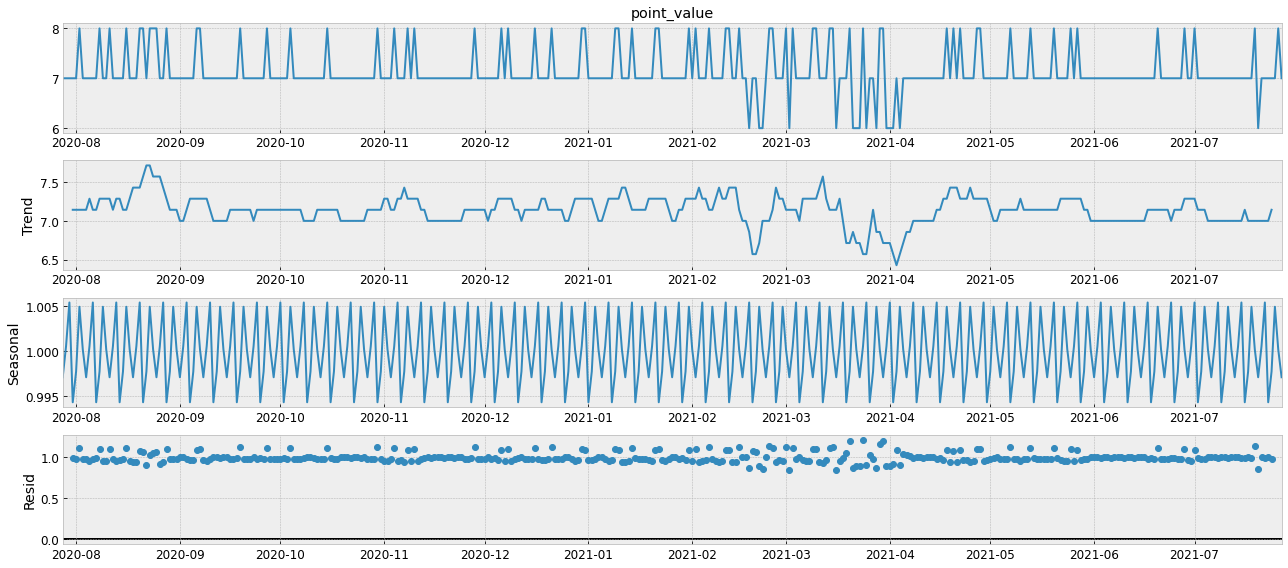

<Figure size 4000x1600 with 0 Axes>

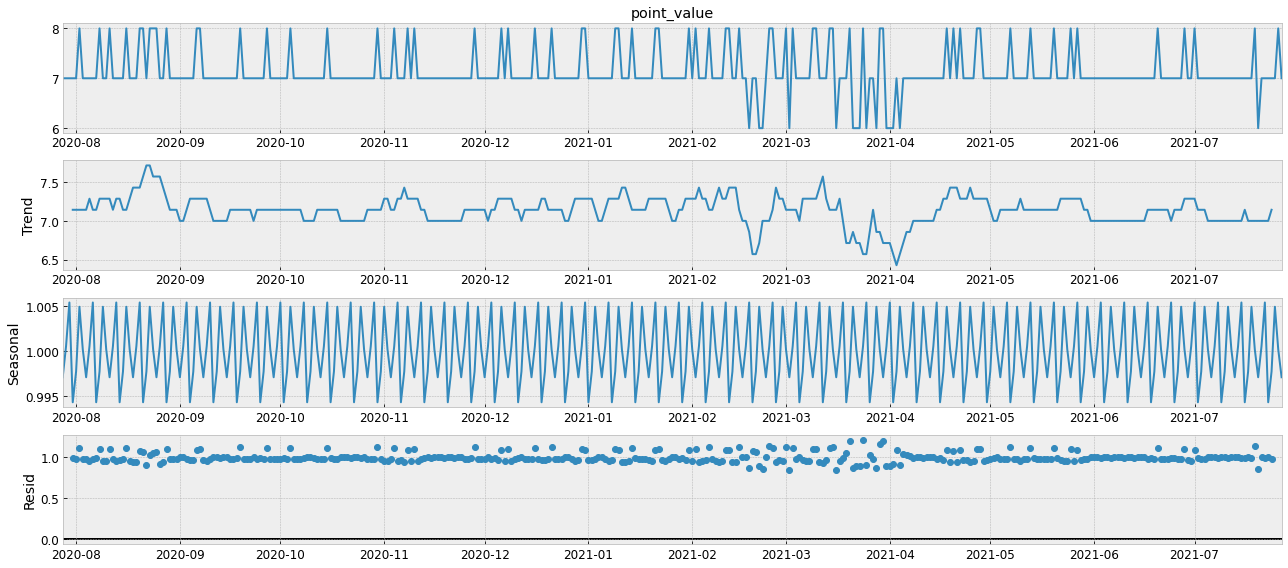

In [19]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = data.point_value[-365:]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

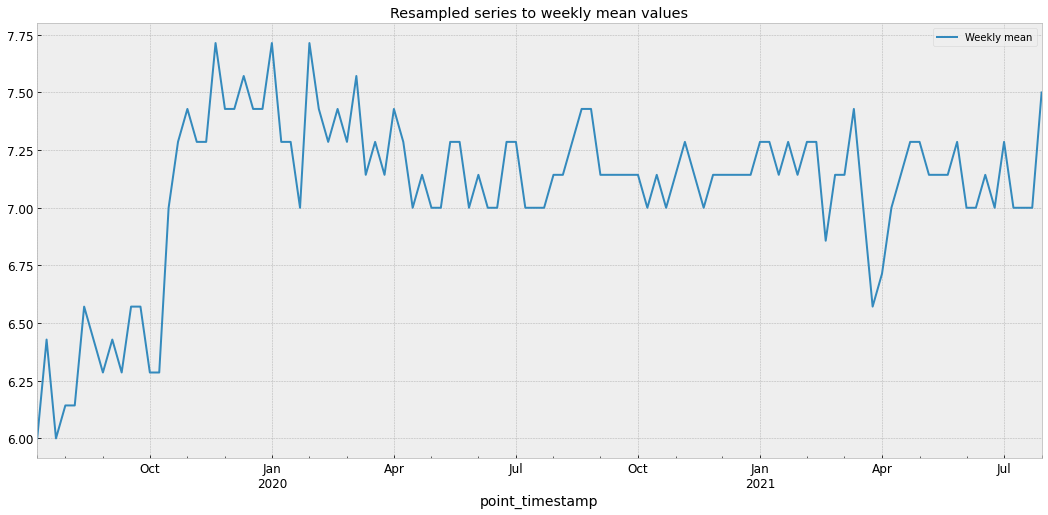

In [20]:
#INTERPRETATION
# Looking for weekly seasonality
resample = data.resample('W')
weekly_mean = resample.mean()
weekly_mean.point_value.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()

Text(0.5, 1.0, 'Mean over time')

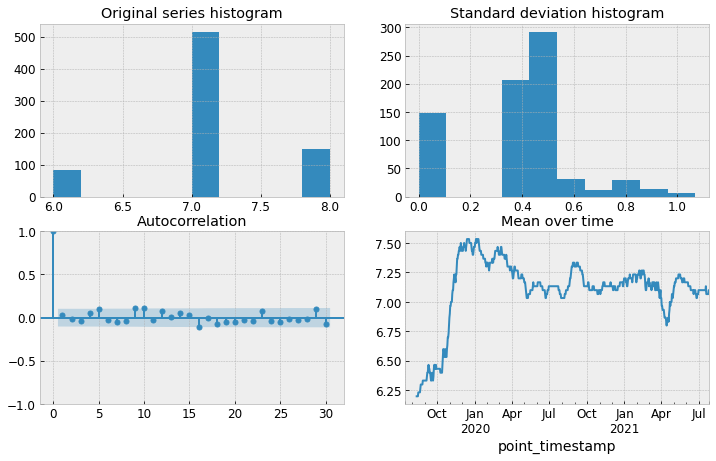

In [21]:
#Noise

fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

data.point_value.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = data.point_value.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = data.point_value.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

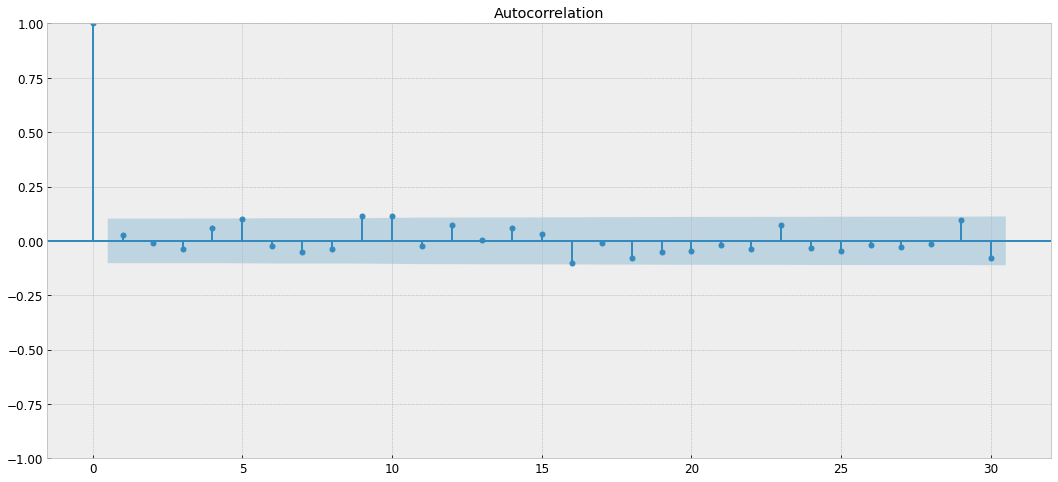

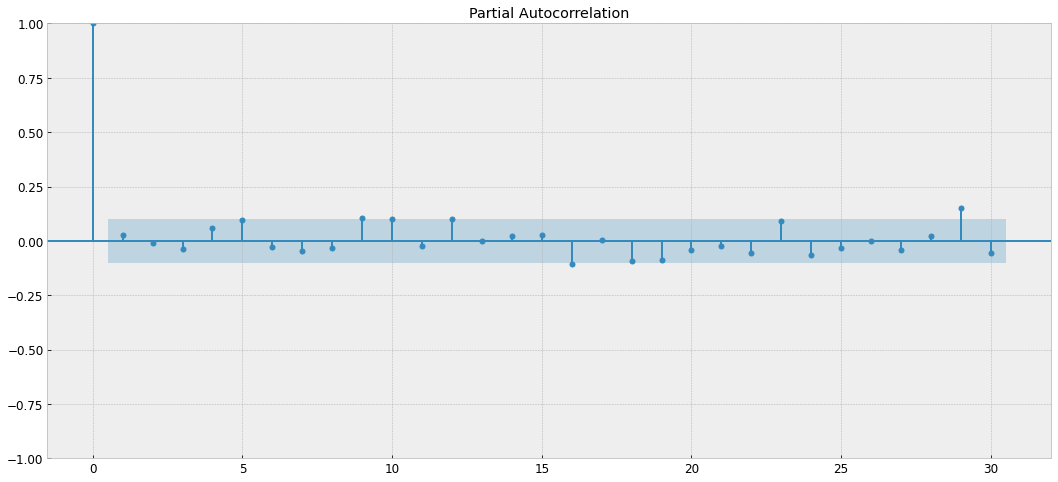

In [22]:
#Stationarity
#Autocorrelation and Partial autocorrelation plots
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()

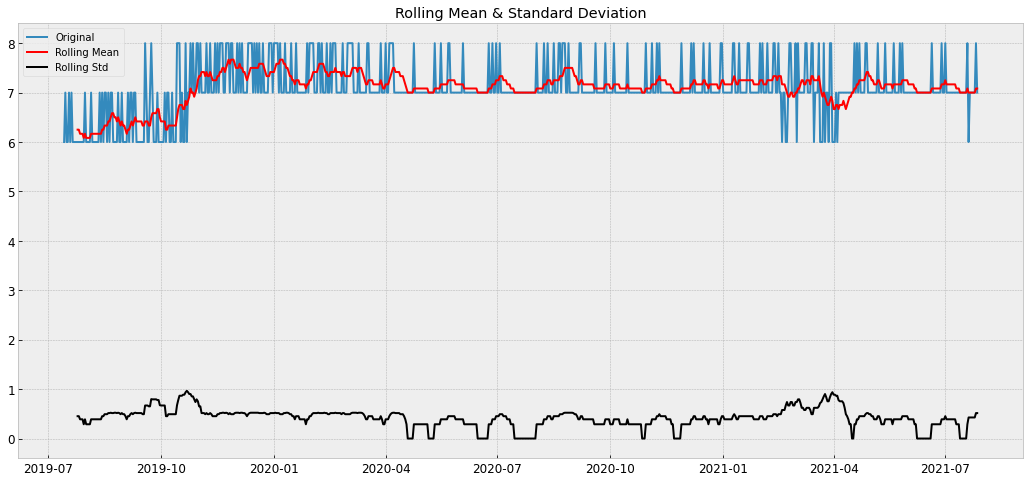

In [23]:
#Rolling means and standard deviation of our series
# Determing rolling statistics
rolmean = data.point_value.rolling(window=12).mean()
rolstd = data.point_value.rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(data.point_value, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [24]:
#Augmented Dickey-Fuller test
X = data.point_value.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.576952
p-value: 0.006217
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


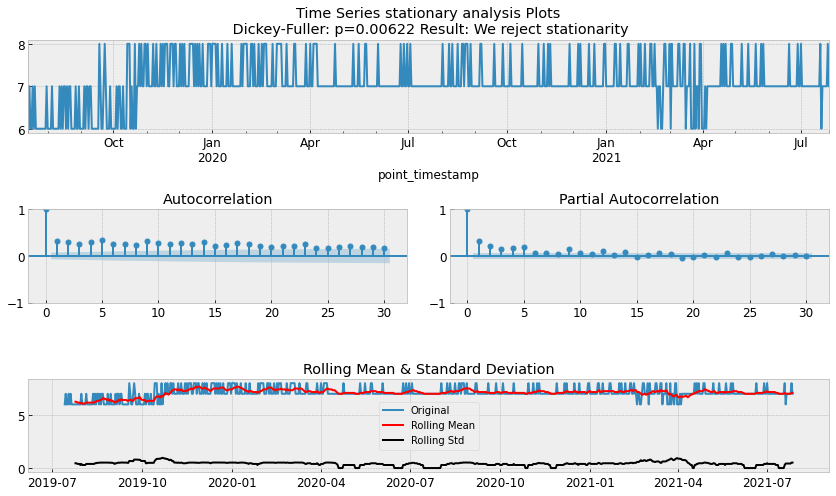

In [25]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = data.point_value.rolling(window=12).mean()
        rolstd = data.point_value.rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(data.point_value, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(data.point_value, lags=30)

Text(0.5, 1.0, 'Original vs Windowed mean vs Windowed std')

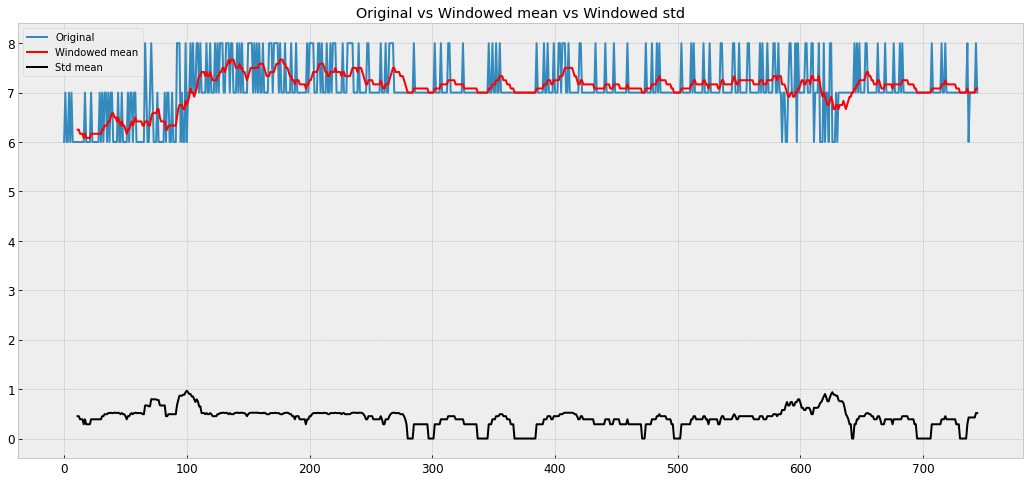

In [26]:
#Making Time Series Stationary
data1 = pd.read_csv("sample_1 (1).csv")
data1.point_value.plot(label='Original')
data1.point_value.rolling(window=12).mean().plot(
    color='red', label='Windowed mean')
data1.point_value.rolling(window=12).std().plot(
    color='black', label='Std mean')
plt.legend()
plt.title('Original vs Windowed mean vs Windowed std')

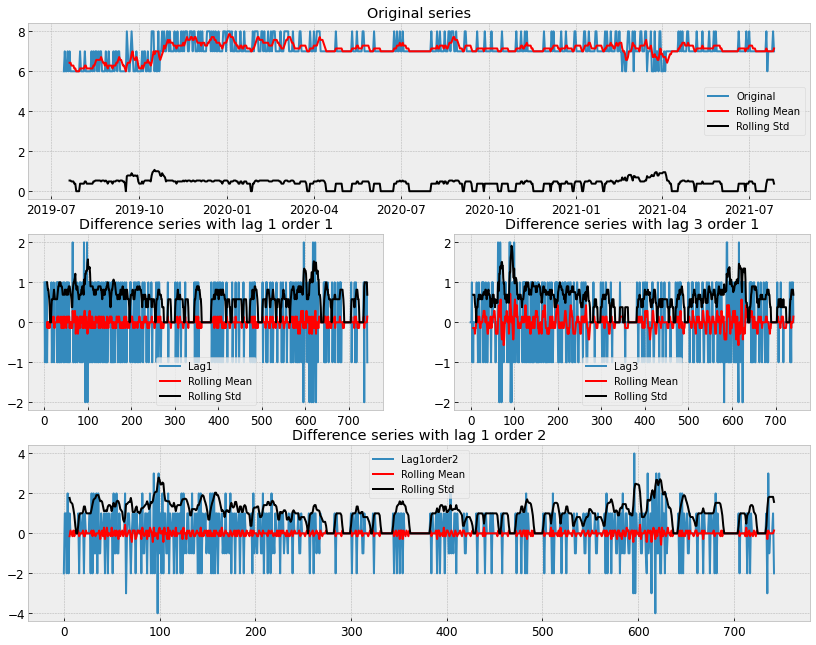

In [27]:
#Difference transform
def difference(dataset, interval=1, order=1):
    for u in range(order):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        dataset = diff
    return diff

lag1series = pd.Series(difference(data.point_value, interval=1, order=1))
lag3series = pd.Series(difference(data.point_value, interval=3, order=1))
lag1order2series = pd.Series(difference(
    data.point_value, interval=1, order=2))

fig = plt.figure(figsize=(14, 11))
layout = (3, 2)
original = plt.subplot2grid(layout, (0, 0), colspan=2)
lag1 = plt.subplot2grid(layout, (1, 0))
lag3 = plt.subplot2grid(layout, (1, 1))
lag1order2 = plt.subplot2grid(layout, (2, 0), colspan=2)

original.set_title('Original series')
original.plot(data.point_value, label='Original')
original.plot(data.point_value.rolling(
    7).mean(), color='red', label='Rolling Mean')
original.plot(data.point_value.rolling(7).std(),
              color='black', label='Rolling Std')
original.legend(loc='best')

lag1.set_title('Difference series with lag 1 order 1')
lag1.plot(lag1series, label="Lag1")
lag1.plot(lag1series.rolling(7).mean(), color='red', label='Rolling Mean')
lag1.plot(lag1series.rolling(7).std(), color='black', label='Rolling Std')
lag1.legend(loc='best')

lag3.set_title('Difference series with lag 3 order 1')
lag3.plot(lag3series, label="Lag3")
lag3.plot(lag3series.rolling(7).mean(), color='red', label='Rolling Mean')
lag3.plot(lag3series.rolling(7).std(), color='black', label='Rolling Std')
lag3.legend(loc='best')

lag1order2.set_title('Difference series with lag 1 order 2')
lag1order2.plot(lag1order2series, label="Lag1order2")
lag1order2.plot(lag1order2series.rolling(7).mean(),
                color='red', label='Rolling Mean')
lag1order2.plot(lag1order2series.rolling(7).std(),
                color='black', label='Rolling Std')
lag1order2.legend(loc='best')

Text(0.5, 1.0, 'Log scale transformation into original series')

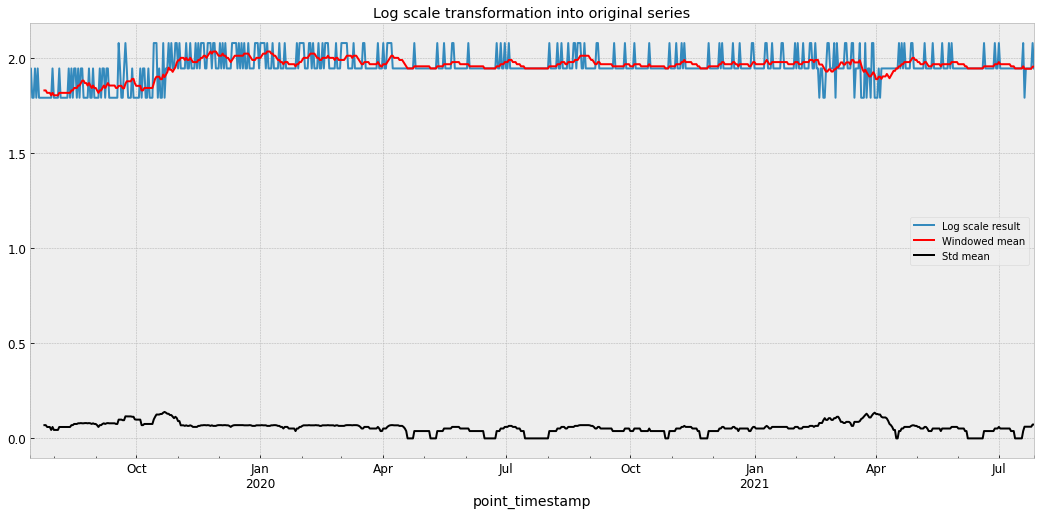

In [28]:
#Log scale transformation
ts_log = np.log(data.point_value)
ts_log.plot(label='Log scale result')
ts_log.rolling(window=12).mean().plot(color='red', label='Windowed mean')
ts_log.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()
plt.title('Log scale transformation into original series')

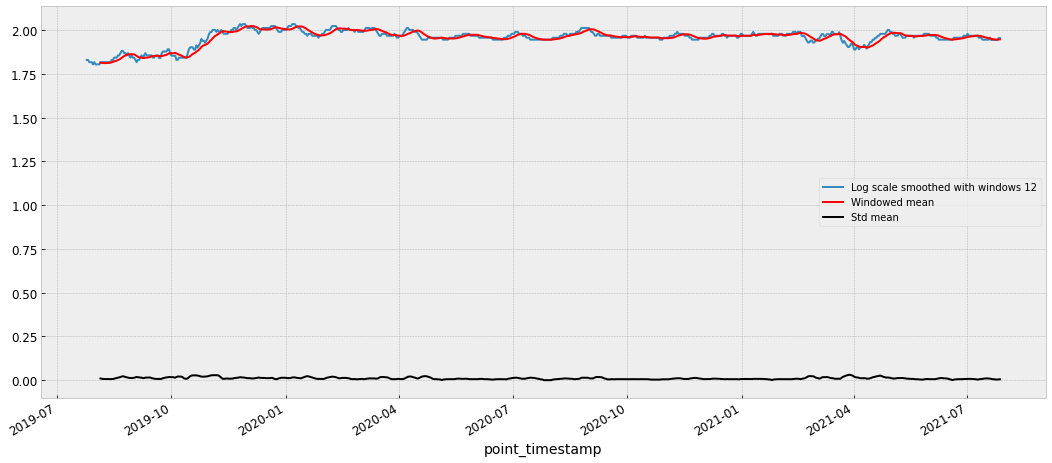

In [29]:
#Smoothing
avg = pd.Series(ts_log).rolling(12).mean()
plt.plot(avg, label='Log scale smoothed with windows 12')
avg.rolling(window=12).mean().plot(color='red', label='Windowed mean')
avg.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()

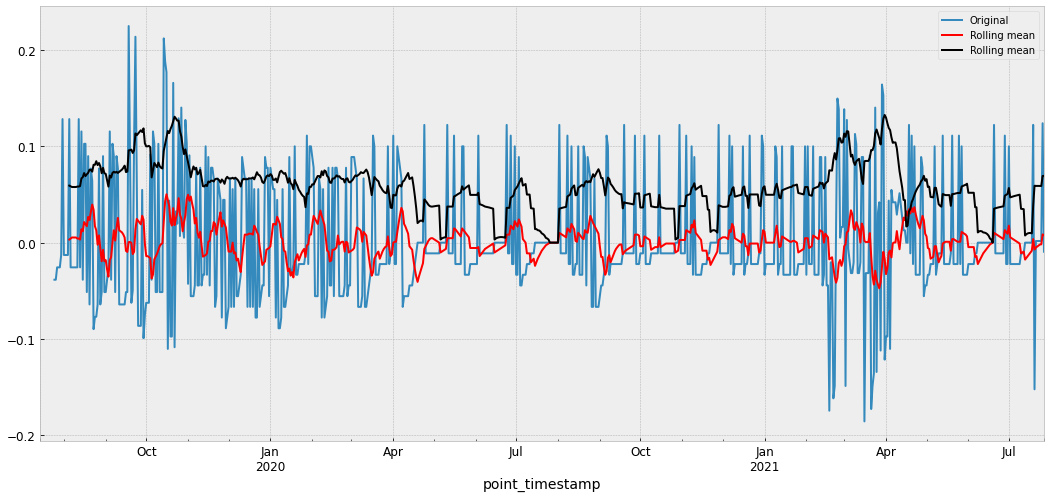

In [30]:
ts_log_moving_avg_diff = ts_log - avg

ts_log_moving_avg_diff.plot(label='Original')
ts_log_moving_avg_diff.rolling(12).mean().plot(
    color='red', label="Rolling mean")
ts_log_moving_avg_diff.rolling(12).std().plot(
    color='black', label="Rolling mean")
plt.legend(loc='best')

In [31]:
#Methods for time series forecasting

# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_fraction = 0.8  # 80% for training, 20% for testing
n_obs = len(data)
split_index = int(split_fraction * n_obs)
split_date = data.index[split_index]

df_training = data.loc[data.index <= split_date]
df_test = data.loc[data.index > split_date]

print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

597 days of training data 
 148 days of testing data 


In [34]:
#Univariate-time-series-forecasting
from tqdm import tqdm

#Simple Exponential Smoothing (SES)

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.point_value))):
    temp_train = data[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.point_value)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.point_value, yhat.values)
predictionsDict['SES'] = yhat.values
#print(predictionsDict['SES'])

100%|██████████| 148/148 [00:03<00:00, 46.97it/s]


[7.17486501 7.07758472 7.15380227 7.1412113  7.12964988 7.11902701
 7.10926353 7.10028925 7.17384926 7.24167192 7.22160793 7.20340479
 7.1868032  7.25322683 7.31566681 7.20646773 7.18991759 7.17471396
 7.16072474 7.22779529 7.13020296 7.03947688 6.95177041 7.04100824
 6.95564057 6.95940548 6.96281143 6.88104886 6.97643781 7.05775835
 6.97506582 6.89651707 6.82065994 6.83627771 6.76342702 6.78455451
 6.8031974  6.81983281 6.83480017 6.84835016 6.86067391 6.87192128
 6.88221276 6.89164751 6.90030883 6.90826798 6.91558692 6.92232027
 7.00832588 7.00765307 7.08863751 7.08121092 7.15894148 7.14508361
 7.13270245 7.1215575  7.11146949 7.18564159 7.25684717 7.23386517
 7.21355268 7.19540106 7.17904519 7.16421829 7.15071844 7.13838798
 7.12710021 7.19839428 7.18203308 7.16713273 7.15351654 7.14104412
 7.12960069 7.2002165  7.1838703  7.16894159 7.1552689  7.1427224
 7.13119474 7.12059483 7.19151126 7.17602959 7.16184893 7.14883285
 7.13686933 7.20617975 7.18955924 7.25495378 7.2341769  7.21528

In [35]:
#Holt Winter’s Exponential Smoothing (HWES)

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.point_value))):
    temp_train = data[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.point_value)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test.point_value, yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 148/148 [00:02<00:00, 60.56it/s]


In [36]:
# ARIMA 

from statsmodels.tsa.arima.model import ARIMA

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.point_value))):
    temp_train = data[:len(df_training)+t]
    model = ARIMA(temp_train.point_value, order=(1, 0, 0))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.point_value, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 148/148 [00:21<00:00,  6.93it/s]


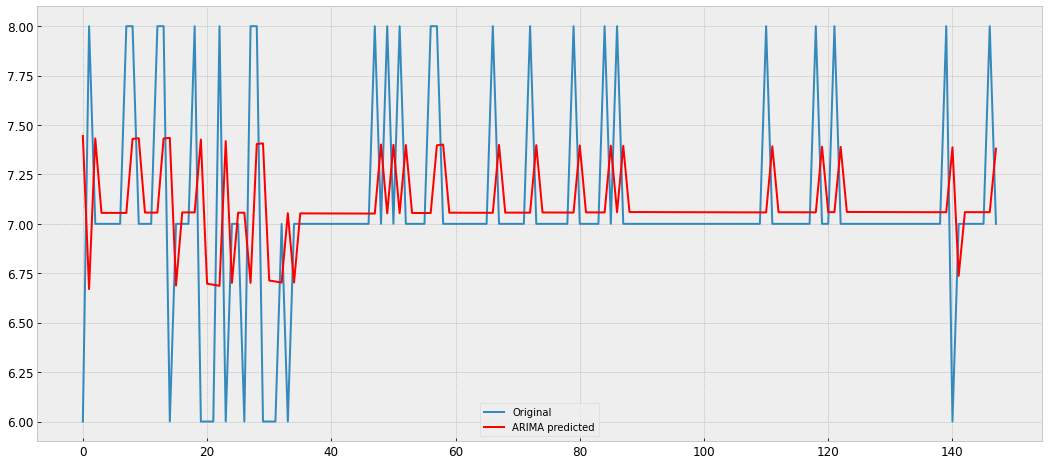

In [37]:
plt.plot(df_test.point_value.values, label='Original')
plt.plot(yhat.values, color='red', label='ARIMA predicted')
plt.legend()

In [38]:
#Auto ARIMA

# building the model

autoModel = pm.auto_arima(df_training.point_value, trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(df_training.point_value)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=805.394, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1127.869, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=983.308, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=801.545, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1125.887, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=801.483, Time=1.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=803.480, Time=1.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=803.482, Time=2.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=801.514, Time=0.66 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=935.386, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=800.534, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=800.506, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=800.560, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=981.330, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=802

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [39]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(df_test.point_value))):
    temp_train = data[:len(df_training)+t]
    model = ARIMA(temp_train.point_value, order=order)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(
    df_test.point_value, yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

100%|██████████| 148/148 [00:23<00:00,  6.18it/s]


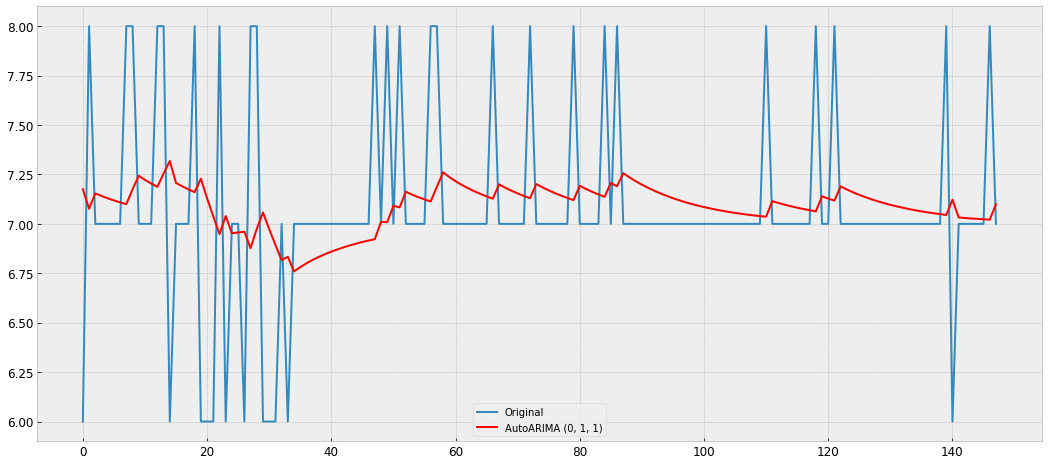

In [40]:
plt.plot(df_test.point_value.values, label='Original')
plt.plot(yhat.values, color='red', label='AutoARIMA {0}'.format(order))
plt.legend()

In [41]:
#Seasonal Autoregressive Integrated Moving-Average (SARIMA)

# SARIMA 

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.point_value))):
    temp_train = data[:len(df_training)+t]
    model = SARIMAX(temp_train.point_value, order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test.point_value, yhat.values)
predictionsDict['SARIMAX'] = yhat.values

100%|██████████| 148/148 [00:11<00:00, 12.58it/s]


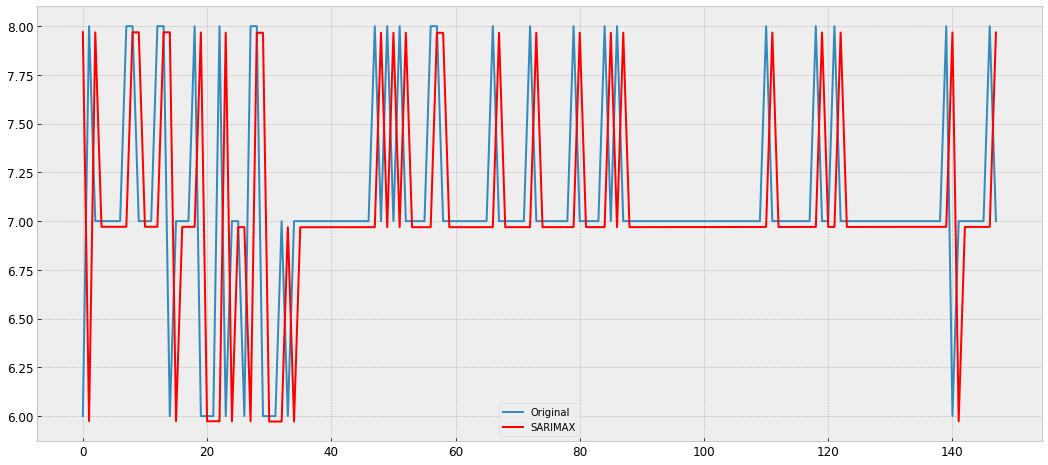

In [42]:
plt.plot(df_test.point_value.values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()

In [43]:
#prophet

prophet_training = df_training.rename(
    columns={'point_value': 'y'})  
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={'point_value': 'y'})  
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [44]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    holidays_prior_scale=20,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
).add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=55
).add_seasonality(
    name='daily',
    period=1,
    fourier_order=15
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=25
).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=20
).add_seasonality(
    name='quarterly',
    period=365.25/4,
    fourier_order=55
).add_country_holidays(country_name='China')

In [45]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet univariate'] = evaluate(
    df_test.point_value, yhat.yhat.values)
predictionsDict['Prophet univariate'] = yhat.yhat.values

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9e0q09y7/lpp6sen2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9e0q09y7/4b8yviet.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53238', 'data', 'file=/tmp/tmp9e0q09y7/lpp6sen2.json', 'init=/tmp/tmp9e0q09y7/4b8yviet.json', 'output', 'file=/tmp/tmp9e0q09y7/prophet_modelg1egr0lm/prophet_model-20230313005253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:52:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:52:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


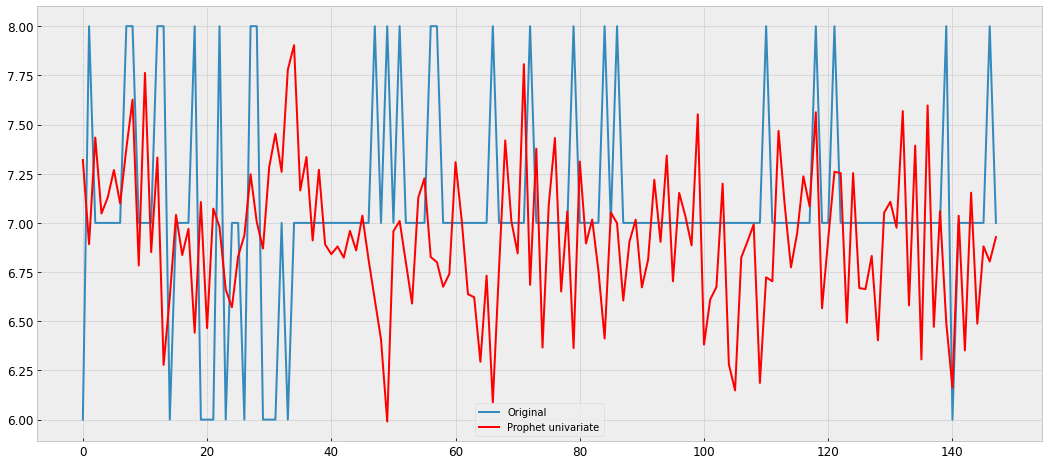

In [46]:
plt.plot(df_test.point_value.values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet univariate')
plt.legend()

In [47]:
#Multivariate time series forecasting
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [48]:
X_train_df, y_train = create_time_features(
    df_training, target='point_value')
X_test_df, y_test = create_time_features(df_test, target='point_value')
scaler = StandardScaler()
scaler.fit(X_train_df)  
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [49]:
#Linear models

#Bayesian regression
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test.point_value, yhat)
predictionsDict['BayesianRidge'] = yhat

In [50]:
#Tree models
#Randomforest
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test.point_value, yhat)
predictionsDict['Randomforest'] = yhat

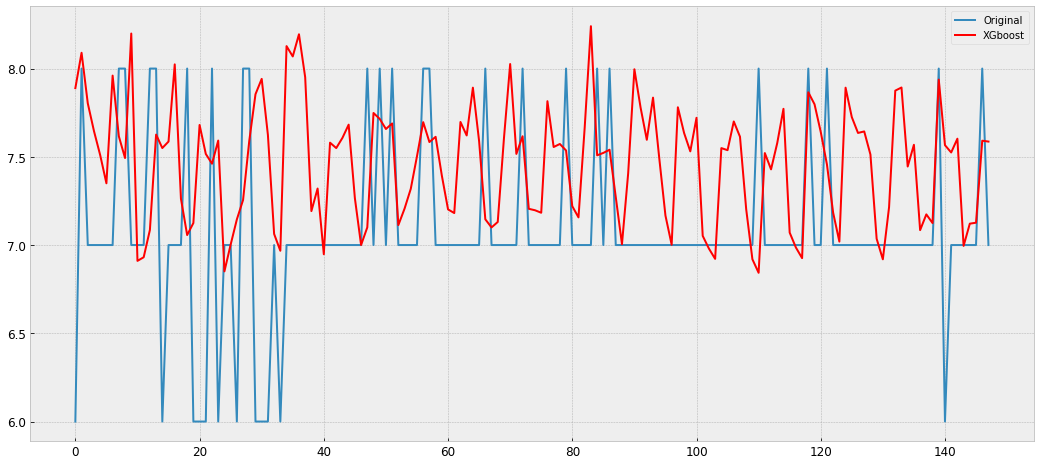

In [51]:
#XGBoost
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.point_value, yhat)
predictionsDict['XGBoost'] = yhat
plt.plot(df_test.point_value.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

In [52]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24


def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [53]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

# logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") #Support for tensorboard tracking!
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [54]:
EVALUATION_INTERVAL = 200
EPOCHS = 5

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50) 

Epoch 1/5
200/200 [==============================] - 20s 57ms/step - loss: 1.0890 - val_loss: 0.5347
Epoch 2/5
200/200 [==============================] - 10s 52ms/step - loss: 0.5645 - val_loss: 0.9093
Epoch 3/5
200/200 [==============================] - 9s 46ms/step - loss: 0.5014 - val_loss: 0.5495
Epoch 4/5
200/200 [==============================] - 12s 60ms/step - loss: 0.4677 - val_loss: 0.3705
Epoch 5/5
200/200 [==============================] - 11s 53ms/step - loss: 0.4430 - val_loss: 0.3549


In [55]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test, yhat)
predictionsDict['Tensorflow simple LSTM'] = yhat

5/5 [==============================] - 1s 13ms/step


In [56]:
import matplotlib.pyplot as plt
import pandas as pd


def bar_metrics(resultsDict):
    df = pd.DataFrame.from_dict(resultsDict)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    pallette = plt.cm.get_cmap("tab20c", len(df.columns))
    colors = [pallette(x) for x in range(len(df.columns))]
    color_dict = dict(zip(df.columns, colors))
    fig = plt.figure(figsize=(20, 15))

    # MAE plot
    fig.add_subplot(2, 2, 1)
    df.loc["mae"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[color_dict.get(x, "#333333") for x in df.loc["mae"].sort_values().index],
    )
    plt.legend()
    plt.title("MAE Metric, lower is better")
    fig.add_subplot(2, 2, 2)
    df.loc["rmse"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["rmse"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("RMSE Metric, lower is better")
    fig.add_subplot(2, 2, 3)
    df.loc["mape"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["mape"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("MAPE Metric, lower is better")
    fig.add_subplot(2, 2, 4)
    df.loc["r2"].sort_values(ascending=False).plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333")
            for x in df.loc["r2"].sort_values(ascending=False).index
        ],
    )
    plt.legend()
    plt.title("R2 Metric, higher is better")
    plt.tight_layout()
    plt.savefig("metrics.jpeg")
    plt.show()


In [57]:
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels()
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

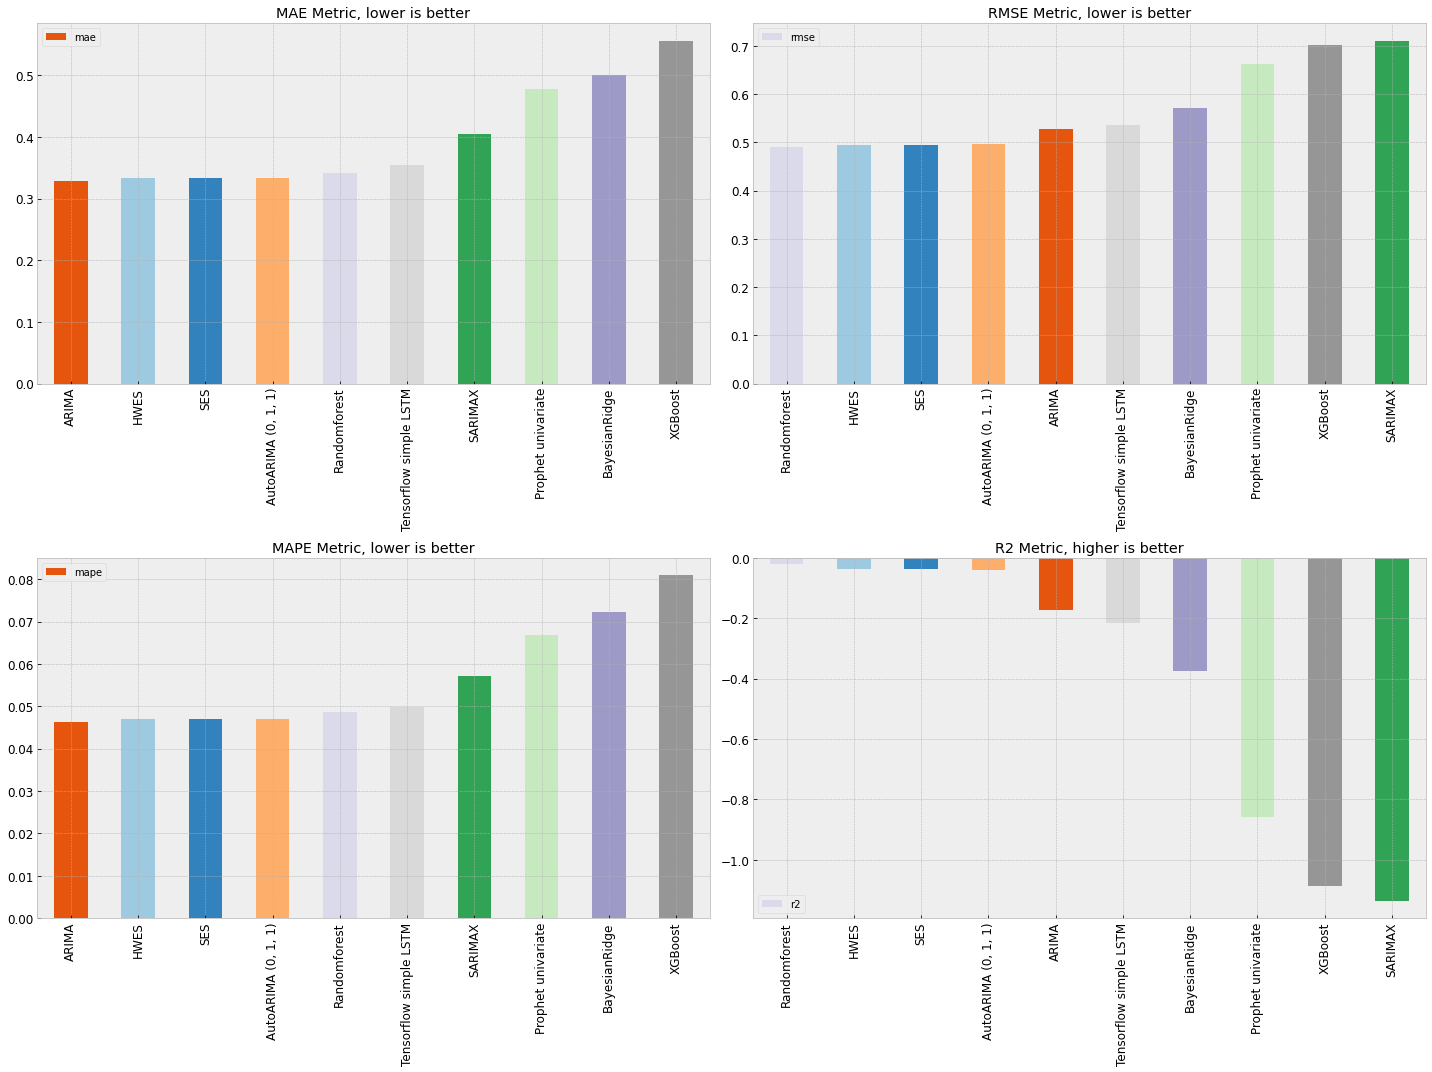

In [58]:
bar_metrics(resultsDict)